In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil

C:\Users\Leapfrog\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

# Define paths
original_dataset_dir = r"dataset\original_data"
base_dir = r"dataset"

# Create directories for training and validation splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)


# Iterate through each category (class) in the raw-img directory
for category in os.listdir(original_dataset_dir):
    category_dir = os.path.join(original_dataset_dir, category)
    
    # Ensure category_dir is a directory
    if os.path.isdir(category_dir):
        images = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
        
        # Debugging: Print out the number of images found
        print(f"Processing category: {category} - {len(images)} images found")

        # Skip this category if there are no images
        if len(images) == 0:
            print(f"No images found in {category}, skipping this category.")
            continue
        
        # Split the images into training and validation sets
        train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)
        
        
        # Create category directories in train and validation folders
        train_category_dir = os.path.join(train_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        validation_category_dir = os.path.join(validation_dir, category)
        os.makedirs(validation_category_dir, exist_ok=True)
        
        # Copy the images
        for image in train_images:
            src = os.path.join(category_dir, image)
            dst = os.path.join(train_category_dir, image)
            shutil.copy2(src, dst)
        
        for image in validation_images:
            src = os.path.join(category_dir, image)
            dst = os.path.join(validation_category_dir, image)
            shutil.copy2(src, dst)

print("Data successfully split into training and validation sets!")

Processing category: cat - 210 images found
Processing category: dog - 210 images found
Processing category: elephant - 210 images found
Processing category: tiger - 210 images found
Data successfully split into training and validation sets!


In [3]:
# Define parameters
image_size = (224, 224)
batch_size = 32

# Image data generator for loading images
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Load dataset from directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)


Found 539 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [4]:
# Load the VGG16 model without the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 30s 2us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,282,564 (16.34 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5


C:\Users\Leapfrog\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 820ms/step - accuracy: 0.3787 - loss: 18.3792 - val_accuracy: 0.5000 - val_loss: 5.0190
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 643ms/step - accuracy: 0.7561 - loss: 1.5387 - val_accuracy: 0.7812 - val_loss: 1.0196
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.9048 - loss: 0.2015 - val_accuracy: 0.9375 - val_loss: 0.1059
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 724ms/step - accuracy: 0.9860 - loss: 0.0360 - val_accuracy: 0.9375 - val_loss: 0.2349
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 729ms/step - accuracy: 0.9878 - loss: 0.0222 - val_accuracy: 0.9375 - val_loss: 0.1175


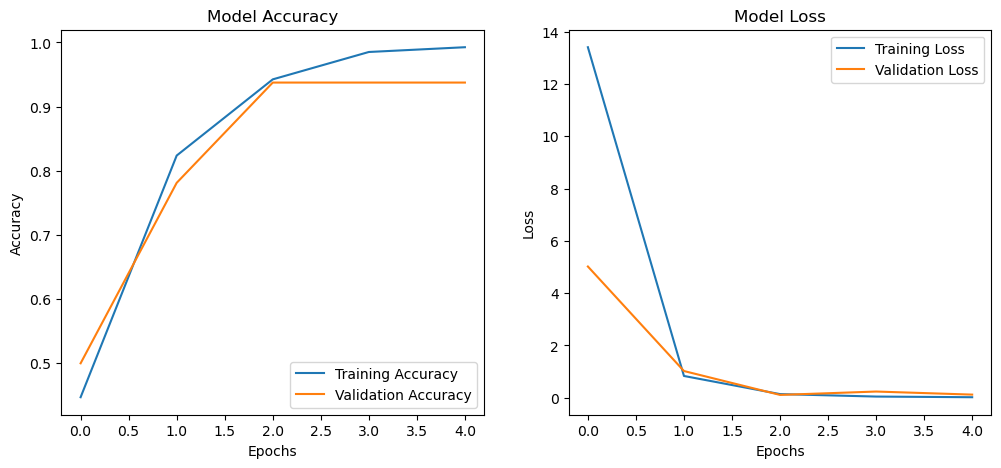

In [6]:
import matplotlib.pyplot as plt


# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [7]:
# Extract features from the training data using the trained model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)  # Output from the dense layer before softmax
# feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_extract').output)
# feature_extractor = Model(inputs=model.input, outputs=predictions)



train_features = feature_extractor.predict(train_generator)
train_labels = train_generator.classes

# Flatten the features for SVM
train_features = train_features.reshape(train_features.shape[0], -1)

# Extract features from the validation data
validation_features = feature_extractor.predict(validation_generator)
validation_labels = validation_generator.classes

# Flatten the features for SVM
validation_features = validation_features.reshape(validation_features.shape[0], -1)


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [8]:
kernel_list = ['linear','rbf','poly','sigmoid']

for kernel in kernel_list:
    # Initialize the SVM classifier
    svm = SVC(kernel=kernel,degree=1,C=0.9)

    # Train the SVM model
    svm.fit(train_features, train_labels)
    # Predict using the SVM classifier
    y_pred = svm.predict(validation_features)

    # Evaluate the performance
    accuracy = accuracy_score(validation_labels, y_pred)
    print(f'Accuracy using {kernel} kernel: {accuracy * 100:.2f}%')

    # Print a classification report
    print(classification_report(validation_labels, y_pred, target_names=validation_generator.class_indices.keys()))

Accuracy using linear kernel: 18.75%
              precision    recall  f1-score   support

         cat       0.18      0.38      0.24         8
         dog       0.25      0.12      0.17         8
    elephant       0.25      0.25      0.25         8
       tiger       0.00      0.00      0.00         8

    accuracy                           0.19        32
   macro avg       0.17      0.19      0.16        32
weighted avg       0.17      0.19      0.16        32

Accuracy using rbf kernel: 28.12%
              precision    recall  f1-score   support

         cat       0.38      0.38      0.38         8
         dog       0.22      0.25      0.24         8
    elephant       0.29      0.25      0.27         8
       tiger       0.25      0.25      0.25         8

    accuracy                           0.28        32
   macro avg       0.28      0.28      0.28        32
weighted avg       0.28      0.28      0.28        32

Accuracy using poly kernel: 25.00%
              precision 

C:\Users\Leapfrog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Leapfrog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Leapfrog\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
